# ML Model - Predict Tournament Finish

## Objectives

* This notebook aims to fulfill business requirement 2:  
   - The client wishes to group elite level golfers based on their skills in order to further determine which style of golfer they could identify for improvement.

## Inputs

* Train, validation and test data:
  - outputs/data/final/train/train_data.csv
  - outputs/data/final/validation/validation_data.csv
  - outputs/data/final/test/test_data.csv

## Outputs

* Write here which files, code or artefacts you generate by the end of the notebook 

## Additional Comments

* As a Random Forest Regression model was chosen as the final model (rather than Gradient Boosting or XG Boost) to use and hyperparameter tuning could be done on the train data using GridSearchCV with a cross-validation of 5, the validation data was not used in this notebook.


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\project-five-golf-data-analytics\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\project-five-golf-data-analytics'

# Download Data and Scaling Pipeline

In [4]:
import pandas as pd

train_data = pd.read_csv("outputs/data/final/train/train_data.csv")
val_data   = pd.read_csv("outputs/data/final/validation/val_data.csv")
test_data  = pd.read_csv("outputs/data/final/test/test_data.csv")
train_data.head()

,player_id,tournament_id,finish_numeric,true_pos,top_ten,mid_band,sg_putt,sg_arg,sg_app,sg_ott,sg_t2g,sg_total,adj_pos
0,9261,401353224,32.0,32.0,0,0,0.20,-0.13,-0.08,0.86,0.65,0.85,0.344444
1,5548,401353224,18.0,18.0,0,1,0.36,0.75,0.31,0.18,1.24,1.60,0.188889
2,4989,401353224,0.0,91.0,0,0,-0.56,0.74,-1.09,0.37,0.02,-0.54,1.000000
3,6015,401353224,0.0,91.0,0,0,-1.46,-1.86,-0.02,0.80,-1.08,-2.54,1.000000
4,3832,401353224,0.0,91.0,0,0,0.53,-0.36,-1.39,0.19,-1.56,-1.04,1.000000


## Remove unnecessary features

In [6]:
cols_to_keep = [
    'player_id',
    'sg_putt',
    'sg_arg',
    'sg_app',
    'sg_ott'
]
train_data_reduced = train_data[cols_to_keep].copy()
val_data_reduced   = val_data[cols_to_keep].copy()
test_data_reduced  = test_data[cols_to_keep].copy()
train_data_reduced.head()

,player_id,sg_putt,sg_arg,sg_app,sg_ott
0,9261,0.20,-0.13,-0.08,0.86
1,5548,0.36,0.75,0.31,0.18
2,4989,-0.56,0.74,-1.09,0.37
3,6015,-1.46,-1.86,-0.02,0.80
4,3832,0.53,-0.36,-1.39,0.19


## Create New DFs with mean strokes gained scores

In [ ]:
def process_df(df):
    """
    Process the input DataFrame to filter players with at least 10 tournaments
    and compute their mean strokes gained statistics.
    """
    counts = (
        df.groupby("player_id")
          .size()
          .reset_index(name="num_tournaments")
    )
    
    df = df.merge(counts, on="player_id")
    
    df_filtered = df[df["num_tournaments"] >= 10]
    
    df_means = (
        df_filtered.groupby("player_id")[['sg_putt', 'sg_arg', 'sg_app', 'sg_ott']]
                   .mean()
                   .reset_index()
    )
    
    return df_means


train_player_means = process_df(train_data_reduced)
val_player_means   = process_df(val_data_reduced)
test_player_means  = process_df(test_data_reduced)

train_player_means.head(30)


,player_id,sg_putt,sg_arg,sg_app,sg_ott
0,5,-0.645000,-0.466667,-0.263333,-0.519583
1,11,0.069355,0.103871,-0.357097,-0.327742
2,16,0.014810,0.480253,-0.234937,-0.648987
3,68,-0.610822,0.060548,0.131233,-0.080000
4,72,-0.113733,0.002800,0.712400,0.359200
5,74,0.144407,0.021186,-0.929661,-0.386780
6,77,-0.100794,0.064286,-0.173651,-0.442540
7,78,-0.071209,-0.121099,0.267582,-0.160440
8,97,-0.982143,-0.468571,-1.097143,-0.185000
9,110,-0.330769,0.005165,0.119890,0.222088


## Begin to create the pipeline
Since all the strokes gained statistics are on a similar numerical scale, scaling is not necessary. Additionally, because all four features are important and the number of features is small, PCA is not needed.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

cluster_features = ['sg_putt', 'sg_arg', 'sg_app', 'sg_ott']

X_train_cluster = train_player_means[cluster_features]

cluster_pipeline = Pipeline([
    ('kmeans', KMeans(n_clusters=8, random_state=42))
])

cluster_pipeline.fit(X_train_cluster)

train_player_means['cluster'] = cluster_pipeline.predict(X_train_cluster)

print(train_player_means.head(20))

cluster_centers = pd.DataFrame(
    cluster_pipeline.named_steps['kmeans'].cluster_centers_,
    columns=cluster_features
)
cluster_centers['cluster'] = range(8)
print("\nCluster Centers (archetypes):")
print(cluster_centers)


    player_id   sg_putt    sg_arg    sg_app    sg_ott  cluster
0           5 -0.645000 -0.466667 -0.263333 -0.519583        2
1          11  0.069355  0.103871 -0.357097 -0.327742        5
2          16  0.014810  0.480253 -0.234937 -0.648987        4
3          68 -0.610822  0.060548  0.131233 -0.080000        6
4          72 -0.113733  0.002800  0.712400  0.359200        1
5          74  0.144407  0.021186 -0.929661 -0.386780        5
6          77 -0.100794  0.064286 -0.173651 -0.442540        4
7          78 -0.071209 -0.121099  0.267582 -0.160440        7
8          97 -0.982143 -0.468571 -1.097143 -0.185000        2
9         110 -0.330769  0.005165  0.119890  0.222088        6
10        123 -0.002500  0.112885 -0.446154 -0.294615        5
11        153  0.043158  0.198947  0.456491 -0.227719        7
12        158 -0.257759  0.008448  0.221207  0.599483        1
13        159  0.263125  0.083542 -0.571979 -0.487396        5
14        167 -0.467442  0.005814  0.063256 -0.397209  

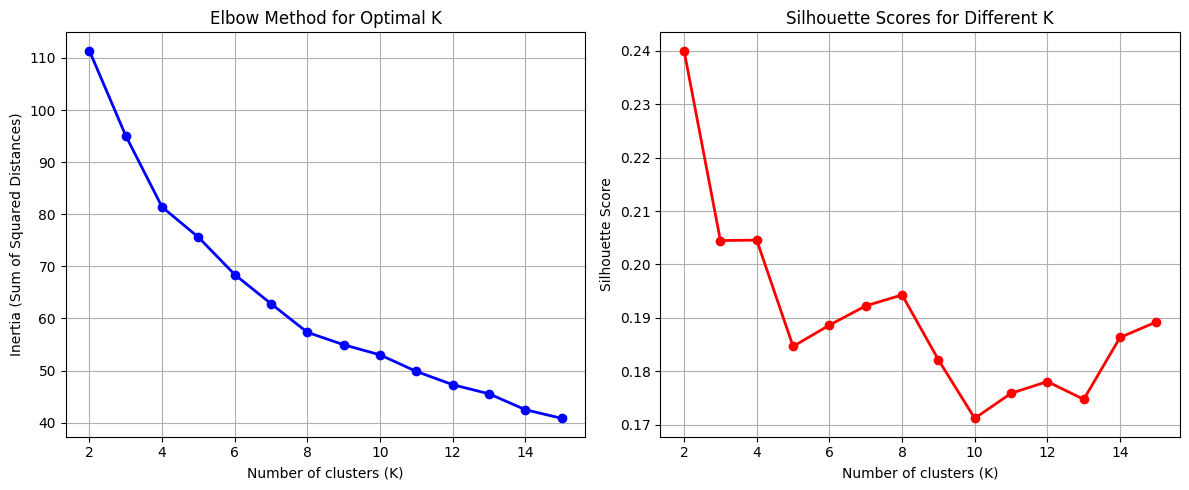

In [12]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

X = train_player_means[cluster_features]

inertia_list = []
silhouette_list = []
K_range = range(2, 16)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    
    inertia_list.append(kmeans.inertia_)
    
    score = silhouette_score(X, labels)
    silhouette_list.append(score)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K_range, inertia_list, 'bo-', linewidth=2)
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal K')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(K_range, silhouette_list, 'ro-', linewidth=2)
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different K')
plt.grid(True)

plt.tight_layout()
plt.show()


These results show that the 'elbow' begins to flatten at 8 clusters and also that the silhouette score is higher at 8 clusters than it is at humbers close to 8. Therefore 8 is the best number of clusters to focus on.